<a href="https://colab.research.google.com/github/dabodobo/Sistemas-Inteligentes/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification example

The main limitation of perceptrons was that they only worked with linearly separable classes.

A multilayer perceptron (MLP) outperforms the linear perceptron and is able to solve linearly non-separable problems.

In this notebook you will learn how to apply the MLP to a typical [classification task](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification). The diagram shown below is a typical workflow diagram for such a task.

![](https://github.com/RobInLabUJI/MultilayerPerceptron/raw/main/img/FeatureExtraction.png)

**1. Preprocessing - getting data into shape**

Raw data rarely comes in the form and shape that is necessary for the optimal performance of an algorithm. The first steps are the preprocessing tasks: loading the data, scaling it, and splitting the data into training and testing sets.

**2. Training and selecting a predictive model**

In our case the predictive model is the MLP, and its parameters need to be set before starting to train.

**3. Evaluating models and predicting unseen data instances**

After we have selected a model that has been fitted on the training data set, we can use the test data set to estimate how well it performs on this unseen data to estimate the generalization error.

*The picture and the description of the process are from ["Python Machine Learning by Sebastian Raschka, 2015"](https://github.com/rasbt/python-machine-learning-book)*

In [1]:
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles
import joblib

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_ds(X_train, X_test, y_train, y_test):
    h = .02
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright);
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6);
    plt.xlim(xx.min(), xx.max()); plt.ylim(yy.min(), yy.max());
    plt.xticks(()); plt.yticks(());

def plot_contour(net,X_train, X_test, y_train, y_test):
    h = .02
    x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
    y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = net.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cm = plt.cm.RdBu
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

%matplotlib inline

## Load in the data

scikit-learn includes various [random sample generators](http://scikit-learn.org/stable/datasets/#sample-generators) that can be used to build artificial datasets of controlled size and complexity. Choose one of these datasets by running one of the two code cells below:

<table border="0">
<tr>
<th>Moons</th>
<th>Circles</th>
</tr>
<tr><td>
<img src="https://github.com/RobInLabUJI/MultilayerPerceptron/raw/main/img/ds_moons.png">
</td><td>
<img src="https://github.com/RobInLabUJI/MultilayerPerceptron/raw/main/img/ds_circles.png">
</td></tr>
</table>

In [ ]:
# Run this cell for using dataset "Moons"
ds = make_moons(n_samples=250, noise=0.3)

In [26]:
# Run this cell for using dataset "Circles"
ds = make_circles(n_samples=2500, noise=0.2, factor=0.5)

## Cross-validation: evaluating network performance

Learning the parameters of the MLP and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called [**overfitting**](https://en.wikipedia.org/wiki/Overfitting). To avoid it, it is common practice  to hold out part of the available data as a test set `[X_test, y_test]`.

In scikit-learn a random split into training and test sets can be quickly computed with the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) helper function.

In [27]:
X, y = ds
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

## Data scaling

Standardization of datasets is a common requirement for neural networks; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

In scikit-learn, the preprocessing module provides a utility class [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) that computes the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.

In [28]:
# Don't cheat - fit only on training data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# apply same transformation to test data
X_test = scaler.transform(X_test)

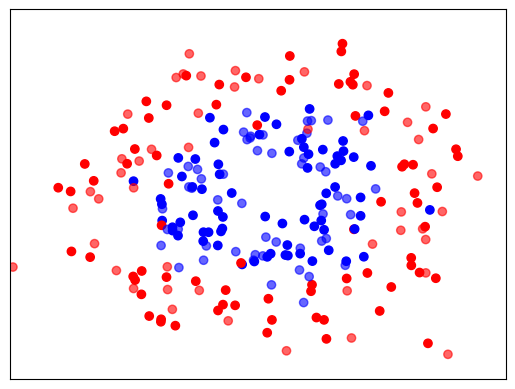

In [5]:
plot_ds(X_train, X_test, y_train, y_test)

## Build the model

Create a [MLP object](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) with the following arguments:
* ‘lbfgs’ solver, which is an optimizer in the family of quasi-Newton methods; for small datasets, it can converge fast and perform pretty well
* one hidden layer with 5 neurons
* 4000 iterations maximum

The rest of the arguments are set to their default values (see documentation).

In [29]:
net = MLPClassifier(solver='lbfgs',\
                    hidden_layer_sizes=(5,),\
                    max_iter=4000)

## Train the network

The `fit` function automatically iterates until convergence or the maximum number of iterations is reached, so you only need to execute the following cell once.

In [30]:
net.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(5,), max_iter=4000, solver='lbfgs')

## Plot decision boundary

Plot the decision boundary as a contour plot. For that, we will assign a color to each point in the plane, which will be proportional to its probability of belonging to one class or the other.

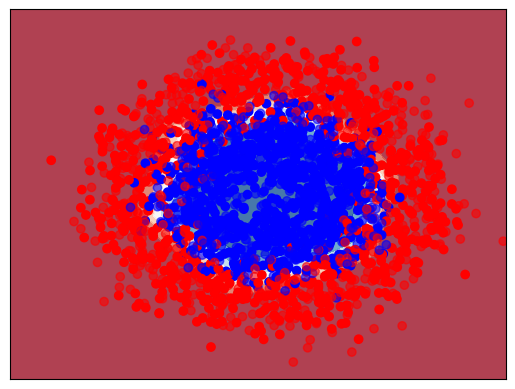

In [31]:
plot_contour(net, X_train, X_test, y_train, y_test)
plot_ds(X_train, X_test, y_train, y_test)

## Analysis of the network

Percentage of correct classification of the test data:

In [32]:
print('Score: %.2f' % (net.score(X_test, y_test)*100))

Score: 90.70


Number of iterations during training:

In [33]:
net.n_iter_

102

Save the dataset, scaler and the network into files.

In [24]:
joblib.dump(ds,'mlp_dataset.pkl')
joblib.dump(scaler, 'mlp_scaler.pkl')
joblib.dump(net, 'mlp_net.pkl')

['mlp_net.pkl']

Download the files (tested in Google Chrome, won't work with Firefox).

In [25]:
from google.colab import files
files.download('mlp_dataset.pkl')
files.download('mlp_scaler.pkl')
files.download('mlp_net.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Can the network do better?

Re-train the network several times with the same dataset, and check what is the highest value for the percentage of correct classification. You may increase the number of hidden neurons, or even use two hidden layers.

## Using a larger dataset

Now increase the size of the dataset from 250 to 2500 and 25000 samples, and repeat the process. What happened?

## File check
You can save the files of your dataset, scaler and network, and check them with [this notebook](https://github.com/RobInLabUJI/MultilayerPerceptron/blob/main/Classification_check.ipynb).

## Workshop

**REMEMBER**: for the **workshop** of sessions 2-4 you will submit the <tt>pkl</tt> files for the dataset, scaler and neural network that solves the classification example.